# Multi Wave Predictor

This notebook is a very simple recurrent neural net using tensorflow to predict the next value/values of multiple waves

In [1]:
# Import dependancies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt, pylab

In [2]:
# set the size of the state
state_size = 4

# set the number of lines to learn in parallel
# we are choosing the sine, cosine and tangent functions
batch_size = 3

iterations = 30000
learning_rate = 0.3

# number of steps to predict into the future
steps_to_predict = 10

# length of array to be inputted, must be >= steps_to_predict
truncated_backprop_length = 40

# total size of training data series
# this calculation will return an array the exact size required
total_series_length = iterations+truncated_backprop_length+steps_to_predict

# dictionary of functions
functions = {0 : np.sin, 1 : np.cos,  2 : np.tan}

In [3]:
# function to generate training data
def generate_data(length, waves):
    
    # create x data for line with max value of length
    # it increases by 0.1 each step
    x = np.linspace(0,length, length*10+1)
    
    # initialize y data array
    y = np.array([])
    
    # for each different wave/line
    for i in range(waves):
        
        # we choose teh functions in order from our functions dictionary
        func = functions[i]
        # append new data for this function and reshape so 1 function per row
        y = np.append(y, func(x)).reshape(i+1,-1)
        
        # normalize data by dividing the values by the max value for this function
        y[i] = y[i]/(np.max(y[i]))

    # return the y data
    return(y)

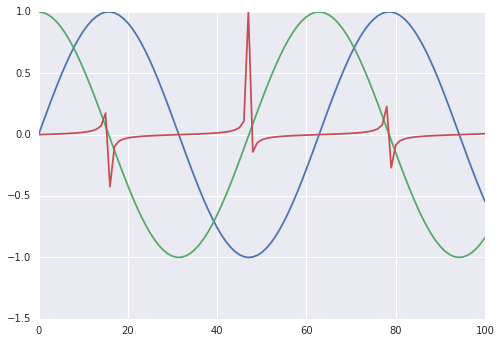

In [4]:
# plot example data
# generate data going up to 10, in 101 steps
line_data = generate_data(10, batch_size)
fig, ax = plt.subplots()

# loop for each function
for i in range(batch_size):
    # plot data but reshape to a 1d array
    ax.plot(line_data[i].reshape(-1))
ax.grid(True)
# show plot
plt.show()

In [5]:
# create placeholders for input data and labels
# we are inputting a set of points and getting back the same number of points 
# the values are steps_to_predict number of steps ahead
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

# create an initial state placeholder
init_state = tf.placeholder(dtype=tf.float32, shape=[batch_size, state_size])

# create Weights and a bias for applying to the output of the RNN cell
W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

# split the input and label array into single arrays
inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchY_placeholder)

In [6]:
# create RNN cell using tensorflows BasicRNNCell function with number of units as state_size
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)
# this runs the RNN cell using our formatted input data series and our initial state
# states_series is the result from the RNN cell which is the same shape as the input data
# the current data is the updated state
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [7]:
# we create our final outputs by applying the weights and bias to the output series
# since we split the input data up, the output data is also split so we need to do this for every individual value
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]

# calculate loss using l2 loss as it is calculating continuous data and not classes
# again repeat this for each value in the logits series
losses = [tf.nn.l2_loss(labels - logits, name=None) for logits, labels in zip(logits_series,labels_series)]

# total the loss for all values predicted
total_loss = tf.reduce_mean(losses)

# we are using Adagrad optimizer
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:
# start session and initialize variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# generate training data
x_data = generate_data(total_series_length, batch_size)

# initialize a current state with zeros
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# start training loop
# start_index is going to be the first value of the batch in this iteration
for start_index in range(iterations):
    
    # set the end index to the last value inthe batch of this iteration
    end_index = start_index + truncated_backprop_length

    # select input data and labels for current batch
    # the input data is selected using the start and end index
    batchX = x_data[:,start_index:end_index]
    # the labels data is selected from the start and end index but steps_to_predict number of steps ahead
    batchY = x_data[:,start_index+steps_to_predict:end_index+steps_to_predict]
    

    # run the training step feeding in the selected data and the current state
    # return the total_loss to print
    # return the train_step to run the optimizer
    # return the current state to update it to the next state
    _total_loss, _train_step, _current_state = sess.run([total_loss, train_step, current_state],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })
    
    # print the index and loss 20 times in total
    if (start_index)%(iterations/20) == 0:
        print 'Step',start_index, 'Loss =', _total_loss
        
# print when training has finished
print 'Done Training'

Step 0 Loss = 0.589548
Step 1500 Loss = 0.171148
Step 3000 Loss = 0.100872
Step 4500 Loss = 0.144255
Step 6000 Loss = 0.139493
Step 7500 Loss = 0.0620253
Step 9000 Loss = 0.0259145
Step 10500 Loss = 0.0541546
Step 12000 Loss = 0.0334605
Step 13500 Loss = 0.0561329
Step 15000 Loss = 0.0203542
Step 16500 Loss = 0.0622909
Step 18000 Loss = 0.020854
Step 19500 Loss = 0.047736
Step 21000 Loss = 0.0212869
Step 22500 Loss = 0.0429868
Step 24000 Loss = 0.0217351
Step 25500 Loss = 0.0432804
Step 27000 Loss = 0.0189821
Step 28500 Loss = 0.0465002
Done Training


In [9]:
# Testing cell

# initialize pred and Y arrays as empty with batch_size rows
pred = Y = np.empty(shape=[batch_size,0])
X = np.array([])

# initialize current state for testing
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# this will be our x values 
n = 0

# loop for 300 steps
for i in range(300):
    
    # initialize addition arrays
    # value temporarily holds the current next value for it's respective function
    # array holds the new values that will be appended to Y or prediction
    new_data_array = new_data_value = np.array([])
    
    # loop, appending each functions new value to the addition array
    for q in range(batch_size):
        func = functions[q]
        new_data_value = func(n)
        new_data_array = np.append(new_data_array, new_data_value).reshape(q+1, 1)
             

    # we append the new data array to Y, our correct line, as a new column (axis 1)
    Y = np.append(Y, new_data_array, axis=1).reshape(batch_size,-1)
    
    # if we haven't got enough points to use as input data
    # dont run the prediction, append the real data for now
    if i < truncated_backprop_length:
        pred = np.append(pred, new_data_array, axis=1).reshape(batch_size,-1)
       
    # when we have enough previous points to use as input data, run the prediction
    # also only run it when it is a multiple of steps_to_predict since it started making predictions
    # this is so it doesn't predict the same points multiple times
    if i >= truncated_backprop_length and (i-truncated_backprop_length) % steps_to_predict == 0:
        
        # set previous, which is our input data, to the last truncated_backprop_length number of points from the real line
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1])
        
        # set new_prediction to the temporary new set of values that have been predicted
        # ignore the values that in the input as well as the output as they are not our predictions
        new_prediction = sess.run(
                [logits_series[-(steps_to_predict):truncated_backprop_length]],
                feed_dict={
                    batchX_placeholder:previous,   # input previous
                    init_state:_current_state      # use current state as state
                })
        
        # concatenate the output values, as they are split up for prediction
        # because they aren't added as new columns, we reshape it so each new time step of values is added as a new row
        # we then transpose it to get the new, predicted values in columns for each time step
        new_prediction = np.transpose(np.concatenate(new_prediction).reshape(-1,batch_size))

        # append teh new predictions to pred along axis 1
        pred = np.append(pred, new_prediction, axis=1)
        
        # update the current state
        _current_state = sess.run(current_state, feed_dict={batchX_placeholder:previous, init_state:_current_state})
        
    # increase the steps by 0.1
    n+= 0.1
    # append X array with current step
    X = np.append(X, n)

# sometimes, the predictions go beyond the real line so we cut them off
pred = pred[:,0:Y[0].size]

# we then normalize the data with max value of 1 for the real line
for i in range(batch_size):
    # we normalize the prediction data using the real data
    pred[i] = pred[i]/(np.max(Y[i]))
    Y[i] = Y[i]/(np.max(Y[i]))

In [10]:
def plot_data(line, X, Y, pred):
  # plot the correct line, Y
  plt.plot(X,Y[line], 'g', label='correct line')

  # plot the  predicted line
  plt.plot(X,pred[line], 'r', label='predicted line')

  # plot the point where the prediction starts
  plt.plot(X[truncated_backprop_length-1], pred[line,truncated_backprop_length-1], 'bo', label='prediction starts here')

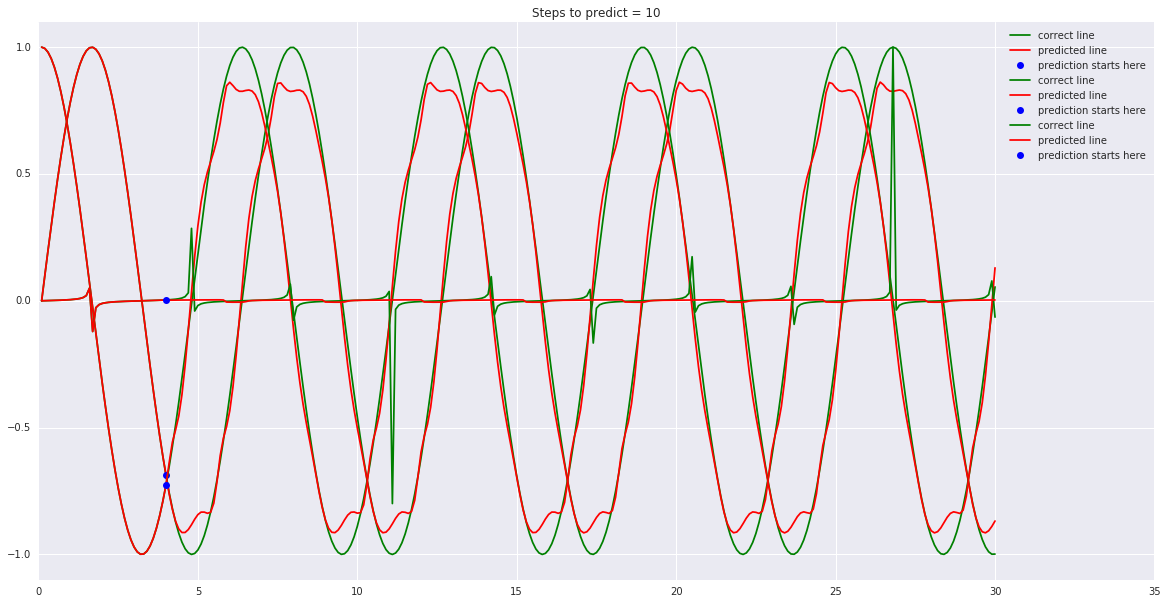

In [11]:
# set up plot
plt.figure(figsize=(20,10))
plt.subplot()
plt.grid(True)
plt.title('Steps to predict = %i' % steps_to_predict)

for i in range(batch_size):
  plot_data(i,X, Y, pred)

# set up more of the plot
plt.legend()
pylab.ylim([-1.1*np.max(pred),1.1*np.max(pred)])
# show the plot
plt.show()